<a href="https://colab.research.google.com/github/rpdahxn/MakeYourFirstGANWithPyTorch/blob/main/10%2C11%2C12_gan_celeba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import h5py
import zipfile
import imageio
import os

In [6]:
%%time

# HDF5 패키지가 위치하는 경로
hdf5_file = 'mount/My Drive/Colab Notebooks/celeba_dataset/celeba_aligned_small.h5py'

# 몇개 이미지를 HDF5로 패키징할지 설정
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('/content/mount/MyDrive/Colab Notebooks/celeba_dataset/source1.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # 이미지 추출
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # 이미지 데이터를 HDF5 파일에 새로운 이름으로 추가
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass
            
          # total_images 수만큼만 추가
          if (count == total_images):
            break
          pass

        pass
      pass

images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000
CPU times: user 2min 46s, sys: 22.1 s, total: 3min 8s
Wall time: 4min 4s


In [7]:
# HDF5 파일을 여러서 내부 그룹을 리스팅함

with h5py.File('mount/My Drive/Colab Notebooks/celeba_dataset/celeba_aligned_small.h5py', 'r') as file_object:
  
  for group in file_object:
    print(group)
    pass

img_align_celeba


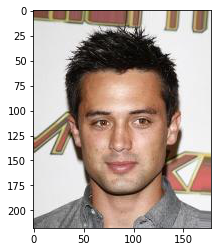

In [9]:
# HDF5 파일을 열어서 예제 이미지를 numpy 행렬로 열고 플롯

import numpy
import matplotlib.pyplot as plt

with h5py.File('mount/My Drive/Colab Notebooks/celeba_dataset/celeba_aligned_small.h5py', 'r') as file_object:
  dataset = file_object['img_align_celeba']
  image = numpy.array(dataset['6.jpg'])
  plt.imshow(image, interpolation='none')
  pass

In [10]:
image.shape

(218, 178, 3)

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random 

In [12]:
# CUDA가 가능한지 확인
# 가능하다면, cuda에 기본 형태를 설정

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla K80


device(type='cuda')

In [13]:
# 데이터셋 클래스


class CelebADataset(Dataset):

  def __init__(self, file):
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba']
    pass

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    if (index >= len(self.dataset)):
      raise IndexError()
    img = numpy.array(self.dataset[str(index)+'.jpg'])
    return torch.cuda.FloatTensor(img) / 255.0

  def plot_image(self, index):
    plt.imshow(numpy.array(self.dataset[str(index) + '.jpg']), interpolation = 'nearest')
    pass

  pass

In [14]:
# Dataset 객체 생성

celeba_dataset = CelebADataset('/content/mount/MyDrive/Colab Notebooks/celeba_dataset/celeba_aligned_small.h5py')

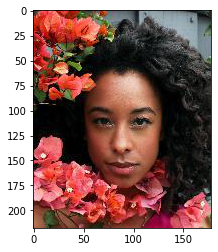

In [16]:
celeba_dataset.plot_image(43)

In [17]:
# 임의의 데이터를 생성하는 함수

def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [22]:
class View(nn.Module):  # 3차원 이미지 텐서를 1차원 이미지 텐서로 바꿔준다.
  def __init__(self, shape):
    super().__init__()
    self.shape = shape,

  def forward(self, x):
    return x.view(*self.shape)

In [20]:
# 판별기 

class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        View(218*178*3),  # 1차원 이미지 텐서로 바꾸기

        nn.Linear(3*218*178, 100),
        nn.LeakyReLU(),

        nn.LayerNorm(100),

        nn.Linear(100, 1),
        nn.Sigmoid()
    )

    self.loss_function = nn.BCELoss()

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
    if (self.counter % 1000 == 0):
      print("counter = ", self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass

  pass

In [23]:
# 판별기 테스트


%%time

D = Discriminator()
# 모델을 cuda로 배치
D.to(device)

for image_data_tensor in celeba_dataset:
  D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
  D.train(generate_random_image((218, 178, 3)), torch.cuda.FloatTensor([0.0]))
  pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 5min 37s, sys: 6.16 s, total: 5min 43s
Wall time: 5min 46s


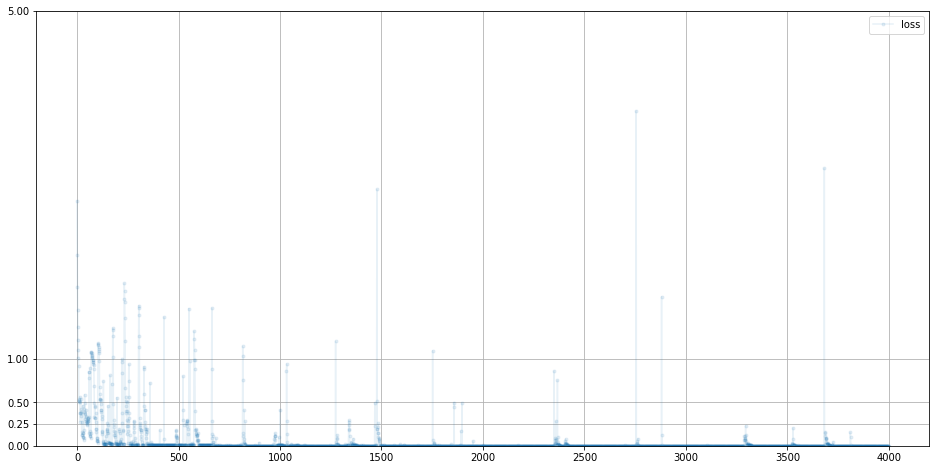

In [24]:
D.plot_progress()

In [25]:
# 가짜와 진짜를 판별할 수 있는지 판별기를 구동해 본다.

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0, 20000)]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random_image((218, 178, 3))).item())
  pass

0.999883770942688
0.9635674357414246
0.9997077584266663
0.9999431371688843
9.801216219784692e-05
0.00010206629667663947
9.455354302190244e-05
0.0001424394577043131


In [33]:
# 생성기

class Generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(100, 3*10*10),
        nn.LeakyReLU(),

        nn.LayerNorm(3*10*10),

        nn.Linear(3*10*10, 3*218*178),
        
        nn.Sigmoid(),
        View((218, 178, 3))  # 3차원 이미지 텐서로 바꾼다.
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, D, inputs, targets):
    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기에 값 전달
    d_output = D.forward(g_output)

    loss = D.loss_function(d_output, targets)

    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass

  pass

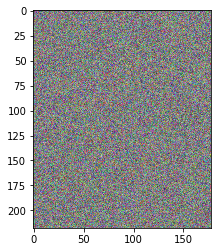

In [34]:
# 생성기의 출력이 올바른지 확인

G = Generator()
# move model to cuda device
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().cpu().numpy()

plt.imshow(img, interpolation = 'none', cmap = 'Blues')

**GAN 훈련**

In [35]:
%%time

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # 판별기와 생성기 훈련

  for image_data_tensor in celeba_dataset:
    # 참일 경우 판별기 훈련
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    
    # 거짓일 경우 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    
    # 생성기 훈련
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 15min 6s, sys: 8.37 s, total: 15min 14s
Wall time: 15min 15s


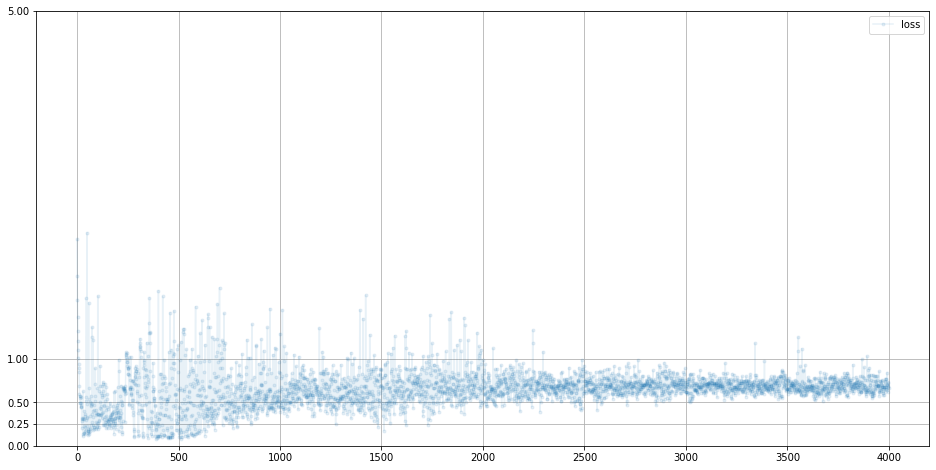

In [36]:
D.plot_progress()

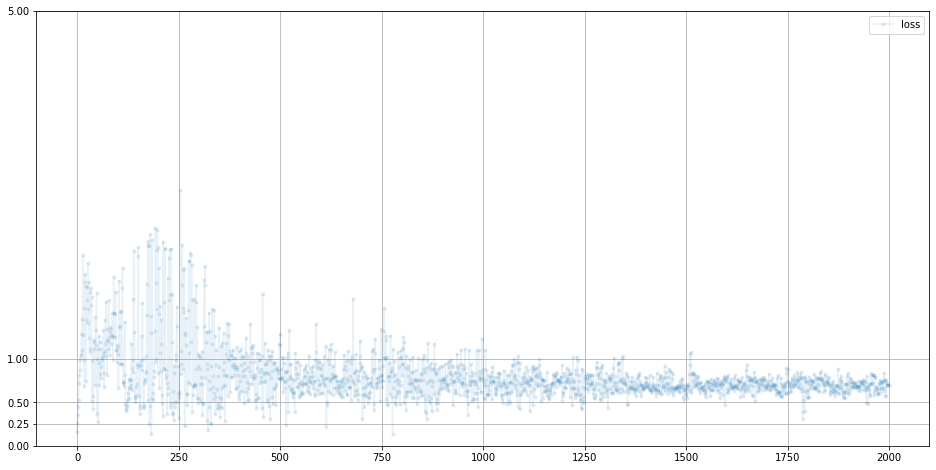

In [37]:
G.plot_progress()

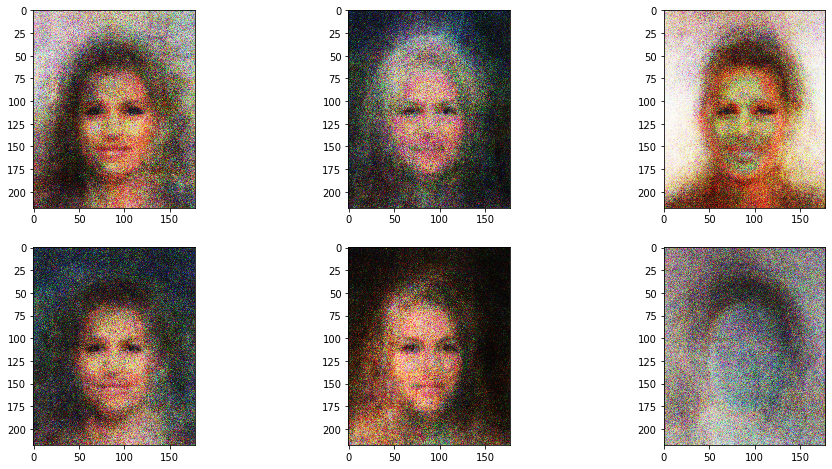

In [38]:
# 훈련된 생성기로부터 몇 개의 출력을 플롯해 본다.

f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().cpu().numpy()
    axarr[i, j].imshow(img, interpolation = 'none', cmap = 'Blues')
    pass
  pass

In [39]:
# 현재 텐서에 할당된 메모리 (기가바이트 단위)

torch.cuda.memory_allocated(device) / (1024*1024*1024)

1.0491228103637695

In [40]:
# 프로그램 실행시 최대 메모리 소비량 (기가바이트 단위)

torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

1.443122386932373

In [41]:
# 메모리 소비 요약

print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1074 MB |    1477 MB |   19251 GB |   19250 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1074 MB |    1477 MB |   19251 GB |   19250 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    1586 MB |    1586 MB |    1586 MB |       0 B  |
|---------------------------------------------------------------